# Microscopie hyperspectrale

Quentin Douzery  
Alexia Ghozland

## 1. Imports

### 1.1. Packages

In [10]:
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
import numpy as np
import os
import math
import pandas as pd
import cv2
import copy
from scipy.stats import mannwhitneyu

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.2. Images

In [12]:
#path_dir = "/content/gdrive/My Drive/Hyperspectral" #drive directory
path_dir = "/content/gdrive/My Drive/Hyperspectral/Images-hyperspectrales"
#path_dir = "/home/douzery/Bureau" #local directory

In [13]:
#Dictionnaire qui contient les fichiers des images originales
raw_images_names = {"j1_1_740nm":os.path.join(path_dir, "j1-740nm/hdf5-images/j1_1_740nm.h5"),
                    "j1_2_740nm":os.path.join(path_dir, "j1-740nm/hdf5-images/j1_2_740nm.h5"),
                    "j5_1_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_1_740nm.h5"),
                    "j5_2_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_2_740nm.h5"),
                    "v2_2_740nm":os.path.join(path_dir, "v2-740nm/hdf5-images/v2_2_740nm.h5"),
                    "v2_3_740nm":os.path.join(path_dir, "v2-740nm/hdf5-images/v2_3_740nm.h5"),
                    "v6_3_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_3_740nm.h5"),
                    "v6_4_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_4_740nm.h5")}

In [14]:
#Dictionnaire qui contient les fichiers des images originales
segmented_images_names = {"j1_1_740nm":os.path.join(path_dir, "j1-740nm/segmented-images/j1_1_740nm_Simple-Segmentation.h5"),
                          "j1_2_740nm":os.path.join(path_dir, "j1-740nm/segmented-images/j1_2_740nm_Simple-Segmentation.h5"),
                          "j5_1_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_1_740nm_Simple-Segmentation.h5"),
                          "j5_2_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_2_740nm_Simple-Segmentation.h5"),
                          "v2_2_740nm":os.path.join(path_dir, "v2-740nm/segmented-images/v2_2_740nm_Simple-Segmentation.h5"),
                          "v2_3_740nm":os.path.join(path_dir, "v2-740nm/segmented-images/v2_3_740nm_Simple-Segmentation.h5"),
                          "v6_3_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_3_740nm_Simple-Segmentation.h5"),
                          "v6_4_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_4_740nm_Simple-Segmentation.h5")}

In [15]:
#Dictionnaire qui contient les images originales (format hdf5)
aux_raw_images = {}
for name, path in raw_images_names.items():
    aux_raw_images[name] = h5py.File(path, 'r')

In [16]:
#Dictionnaire qui contient les images après segmentation (format hdf5)
aux_segmented_images = {}
for name, path in segmented_images_names.items():
    aux_segmented_images[name] = h5py.File(path, 'r')

In [17]:
#Dictionnaire qui contient les images originales (utilisables, tableau Python)
raw_images = {}
for name, img in tqdm(aux_raw_images.items()):
  z = img['data'].shape[1]
  raw_images[name] = np.reshape(img['data'], (z,512,512,32))

100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


In [18]:
#Dictionnaire qui contient les images après segmentation (utilisables, tableau Python)
segmented_images = {}
for name, img in tqdm(aux_segmented_images.items()):
  z = img['exported_data'].shape[1]
  segmented_images[name] = np.reshape(img['exported_data'], (z,512,512))

100%|██████████| 8/8 [00:00<00:00, 56.06it/s]


## 2. Caractéristiques des images

In [19]:
for name, img in raw_images.items():
  print("Dimensions de l'image originale", name, "(z, y, x, c) :", img.shape)
  print("Dimensions de l'image segmentée", name, "(z, y, x) :", segmented_images[name].shape, "\n")

Dimensions de l'image originale j1_1_740nm (z, y, x, c) : (13, 512, 512, 32)
Dimensions de l'image segmentée j1_1_740nm (z, y, x) : (13, 512, 512) 

Dimensions de l'image originale j1_2_740nm (z, y, x, c) : (18, 512, 512, 32)
Dimensions de l'image segmentée j1_2_740nm (z, y, x) : (18, 512, 512) 

Dimensions de l'image originale j5_1_740nm (z, y, x, c) : (12, 512, 512, 32)
Dimensions de l'image segmentée j5_1_740nm (z, y, x) : (12, 512, 512) 

Dimensions de l'image originale j5_2_740nm (z, y, x, c) : (14, 512, 512, 32)
Dimensions de l'image segmentée j5_2_740nm (z, y, x) : (14, 512, 512) 

Dimensions de l'image originale v2_2_740nm (z, y, x, c) : (12, 512, 512, 32)
Dimensions de l'image segmentée v2_2_740nm (z, y, x) : (12, 512, 512) 

Dimensions de l'image originale v2_3_740nm (z, y, x, c) : (15, 512, 512, 32)
Dimensions de l'image segmentée v2_3_740nm (z, y, x) : (15, 512, 512) 

Dimensions de l'image originale v6_3_740nm (z, y, x, c) : (18, 512, 512, 32)
Dimensions de l'image segment

## 3. Pré-traitement

In [20]:
#Création d'un "filtre" pour isoler les valeurs des voxels correspondant à ce qui est du muscle
def Filter_muscle (img):
  z = img.shape[0]
  filter = img - 2*np.ones((z,512,512))
  filter = np.abs(filter)
  return filter

In [21]:
#Création d'un "filtre" pour isoler les valeurs des voxels correspondant à ce qui n'est pas du muscle
def Filter_autre (img):
  z = img.shape[0]
  filter = img - np.ones((z,512,512))
  filter = np.abs(filter)
  return filter

In [22]:
segmented_images_m = {}
for name, img in tqdm(segmented_images.items()):
  segmented_images_m[name] = Filter_muscle(img)

100%|██████████| 8/8 [00:00<00:00, 24.30it/s]


In [23]:
segmented_images_nm = {}
for name, img in tqdm(segmented_images.items()):
  segmented_images_nm[name] = Filter_autre(img)

100%|██████████| 8/8 [00:00<00:00, 21.58it/s]


## 4. Affichage

In [24]:
image_j = "j1_1_740nm"
image_v = "v2_3_740nm"

### 4.1. Raw images

In [25]:
print("Valeurs des 32 canaux du premier voxel d'une image originale :", raw_images["j5_1_740nm"][0][0][0][:], "\n")

Valeurs des 32 canaux du premier voxel d'une image originale : [173 236 207 191  34 160  45 193 187 247  64  93 312  84 264 204 140 224
 125 180  95 146 130 183 179 120   2 119 261 158 177 119] 



### 4.2. Segmented images

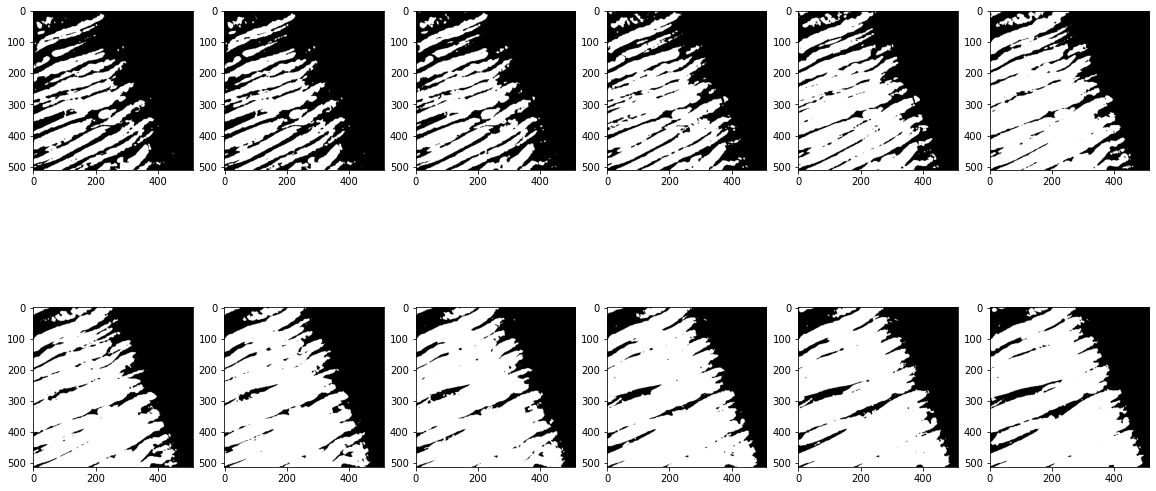

In [26]:
z=0
fig, axs = plt.subplots(2,6, figsize=(20, 10))
for i in range(2):
  for j in range(6):
    Zi = segmented_images_m[image_j][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

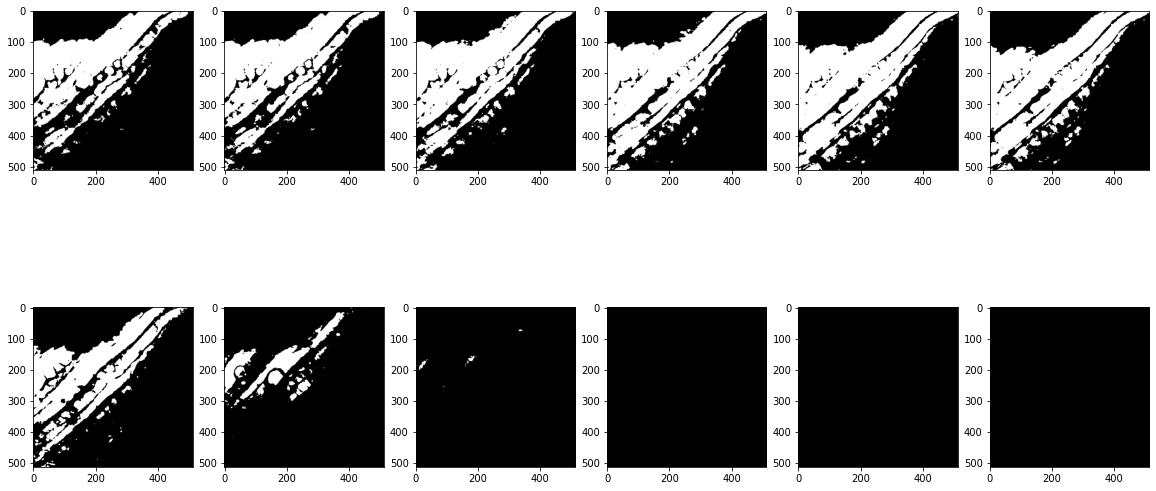

In [27]:
z=0
fig, axs = plt.subplots(2,6, figsize=(20, 10))
for i in range(2):
  for j in range(6):
    Zi = segmented_images_m[image_v][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

## 5. Ouverture

In [28]:
##Création du dictionnaire qui va contenir les images après ouverture
open_segmented_images_m = copy.deepcopy(segmented_images_m)
open_segmented_images_nm = copy.deepcopy(segmented_images_nm)

In [29]:
kernel_o=np.ones((20,20),np.uint8) #kernel rectangulaire pour ouverture
kernel_e=np.ones((15,15),np.uint8) #kernel rectangulaire pour érosion
kernel_d=np.ones((25,25),np.uint8) #kernel rectangulaire pour dilatation
#kernel2=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) #kernel elliptique

### 5.1. Ouverture + érosion

In [30]:
for name, img in open_segmented_images_m.items():
  for z in range(img.shape[0]):
    img[z,:,:] = cv2.morphologyEx(img[z,:,:], cv2.MORPH_OPEN, kernel_o)
    img[z,:,:] = cv2.erode(img[z,:,:], kernel_e, iterations = 1)

### 5.2. Ouverture + dilatation

In [31]:
for name, img in open_segmented_images_nm.items():
  for z in range(img.shape[0]):
    img[z,:,:] = cv2.morphologyEx(img[z,:,:], cv2.MORPH_OPEN, kernel_o)
    img[z,:,:] = cv2.dilate(img[z,:,:], kernel_d, iterations = 1)

### 5.3. Affichage

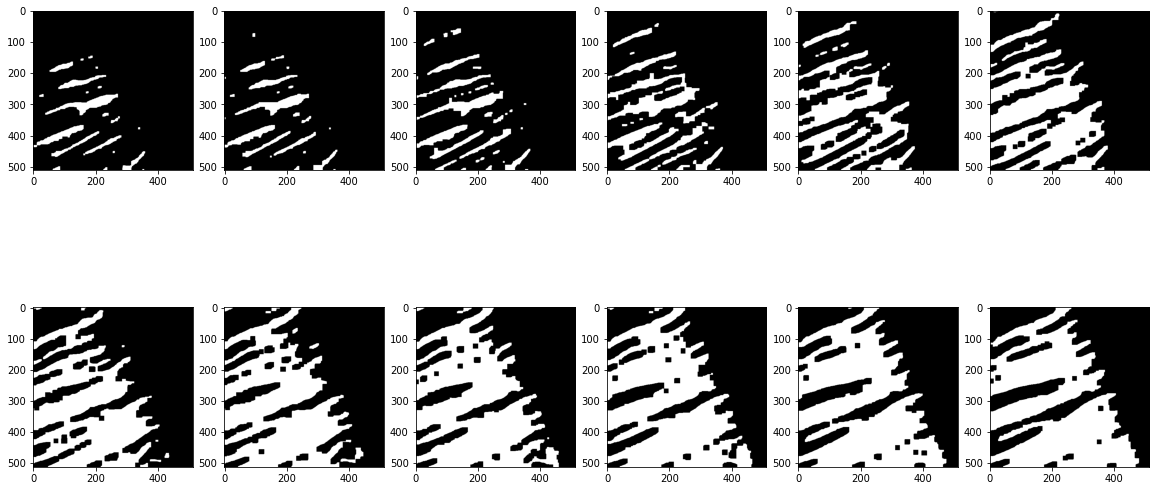

In [32]:
z=0
fig, axs = plt.subplots(2,6, figsize=(20, 10))
for i in range(2):
  for j in range(6):
    Zi = open_segmented_images_m[image_j][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

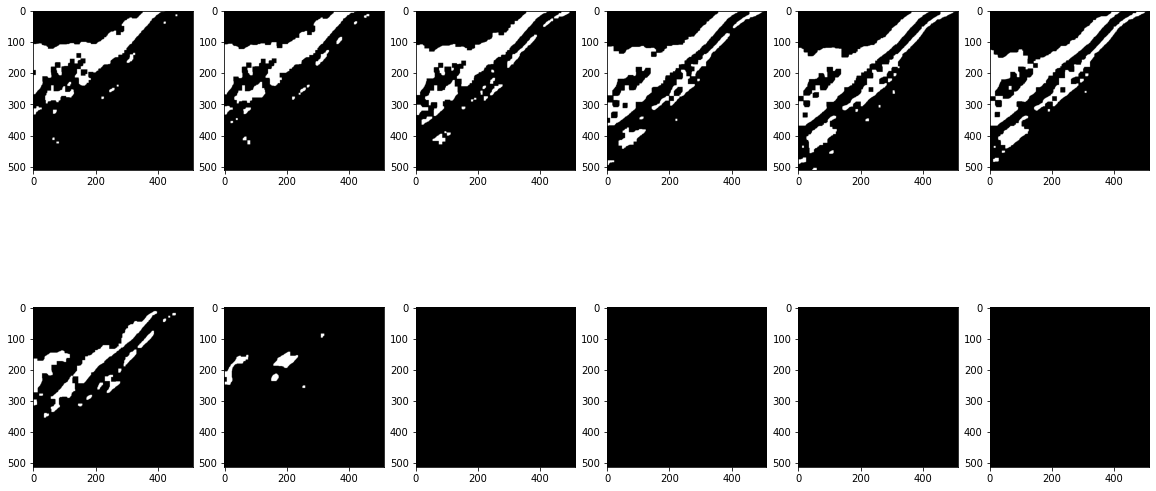

In [33]:
z=0
fig, axs = plt.subplots(2,6, figsize=(20, 10))
for i in range(2):
  for j in range(6):
    Zi = open_segmented_images_m[image_v][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

## 6. Spectres moyens des images (muscle)


In [34]:
def Mean_spectrum (img, os_img):
  #Utile
  MEAN_SPECTRUM = np.zeros(32) #initialisation du spectre moyen

  #Calcul du spectre moyen
  for i in range(32):
    muscle = os_img*img[:,:,:,i]
    MEAN_SPECTRUM[i] = np.sum(muscle)/np.sum(os_img)

  return MEAN_SPECTRUM

In [35]:
def Rename (old_name):
  new_name = ""
  if old_name[0] == "j":
    new_name += "young_"
  else:
    new_name += "old_"
  
  new_name += old_name[1:4]

  return new_name

In [36]:
MeanS_J = {}
MeanS_V = {}
for name, img in raw_images.items():
  if name[0] == "j":
    MeanS_J[name] = Mean_spectrum(img, open_segmented_images_m[name])
  else:
    MeanS_V[name] = Mean_spectrum(img, open_segmented_images_m[name])

In [56]:
esthetic = {"j1_1_740nm":['-', 'o'], "j1_2_740nm":['-', 'x'], "j5_1_740nm":['--', 'o'], "j5_2_740nm":['--', 'x'],
            "v2_2_740nm":['-', 'o'], "v2_3_740nm":['-', 'x'], "v6_3_740nm":['--', 'o'], "v6_4_740nm":['--', 'x']}

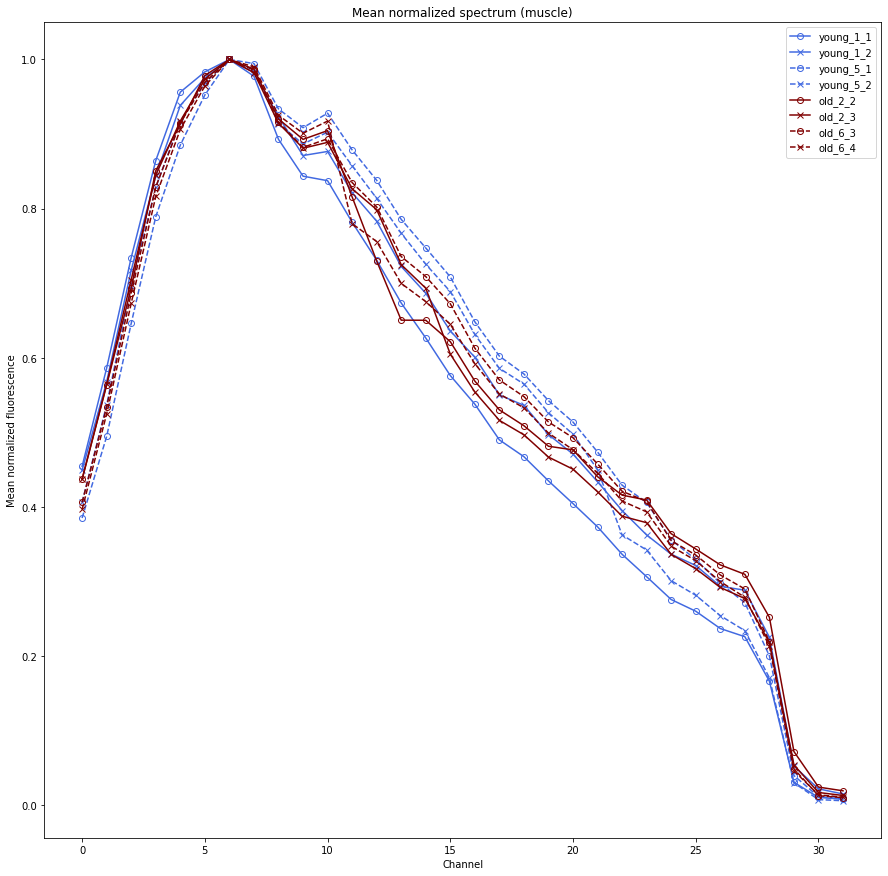

In [57]:
plt.figure(figsize=(15,15))
for name, spec in MeanS_J.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='royalblue', ls=ls, marker=marker, fillstyle='none')
for name, spec in MeanS_V.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='maroon', ls=ls, marker=marker, fillstyle='none')
plt.ylabel("Mean normalized fluorescence")
plt.xlabel("Channel")
plt.title("Mean normalized spectrum (muscle)")
plt.legend()
plt.show()

## 7. Spectres médians des images (muscle)

In [58]:
def Median_spectrum (img, os_img):
  #Utile
  MEDIAN_SPECTRUM = np.zeros(32) #initialisation du spectre médian

  #Calcul du spectre médian
  for i in range(32):
    muscle = os_img*img[:,:,:,i]
    MEDIAN_SPECTRUM[i] = np.median(muscle[muscle != 0])

  return MEDIAN_SPECTRUM

In [59]:
MedianS_J = {}
MedianS_V = {}
for name, img in raw_images.items():
  if name[0] == "j":
    MedianS_J[name] = Median_spectrum(img, open_segmented_images_m[name])
  else:
    MedianS_V[name] = Median_spectrum(img, open_segmented_images_m[name])

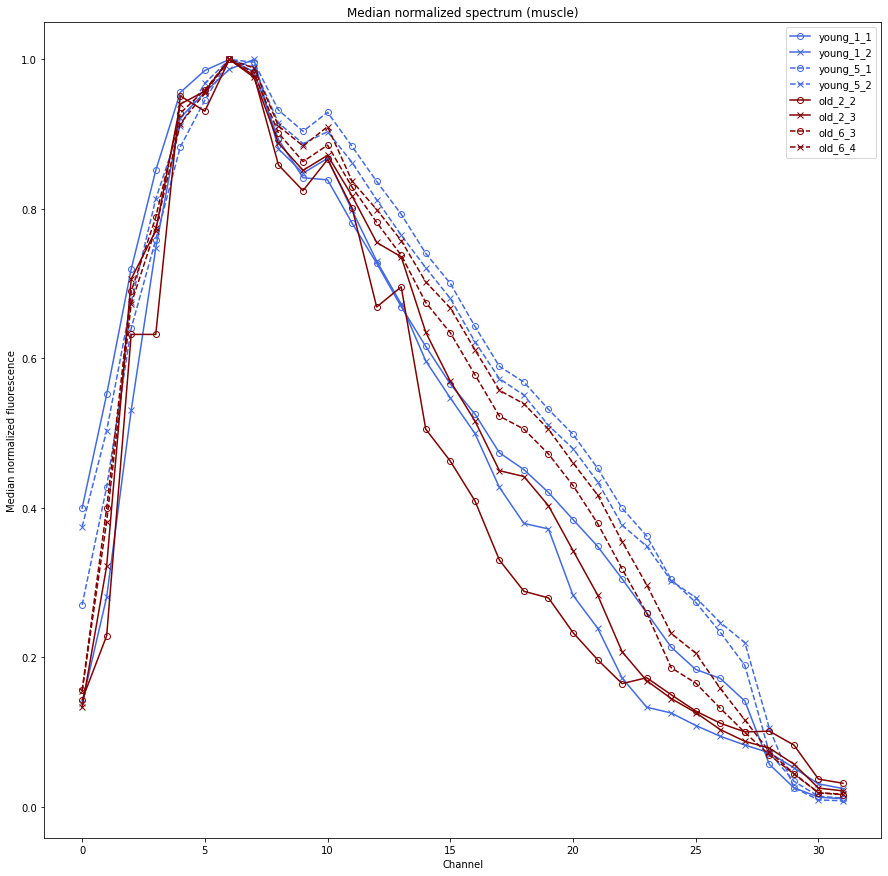

In [60]:
plt.figure(figsize=(15,15))
for name, spec in MedianS_J.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='royalblue', ls=ls, marker=marker, fillstyle='none')
for name, spec in MedianS_V.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='maroon', ls=ls, marker=marker, fillstyle='none')
plt.ylabel("Median normalized fluorescence")
plt.xlabel("Channel")
plt.title("Median normalized spectrum (muscle)")
plt.legend()
plt.show()

## 8. Spectres moyens des images (non muscle)


In [62]:
MeanS_J_nm = {}
MeanS_V_nm = {}
for name, img in raw_images.items():
  if name[0] == "j":
    MeanS_J_nm[name] = Mean_spectrum(img, open_segmented_images_nm[name])
  else:
    MeanS_V_nm[name] = Mean_spectrum(img, open_segmented_images_nm[name])

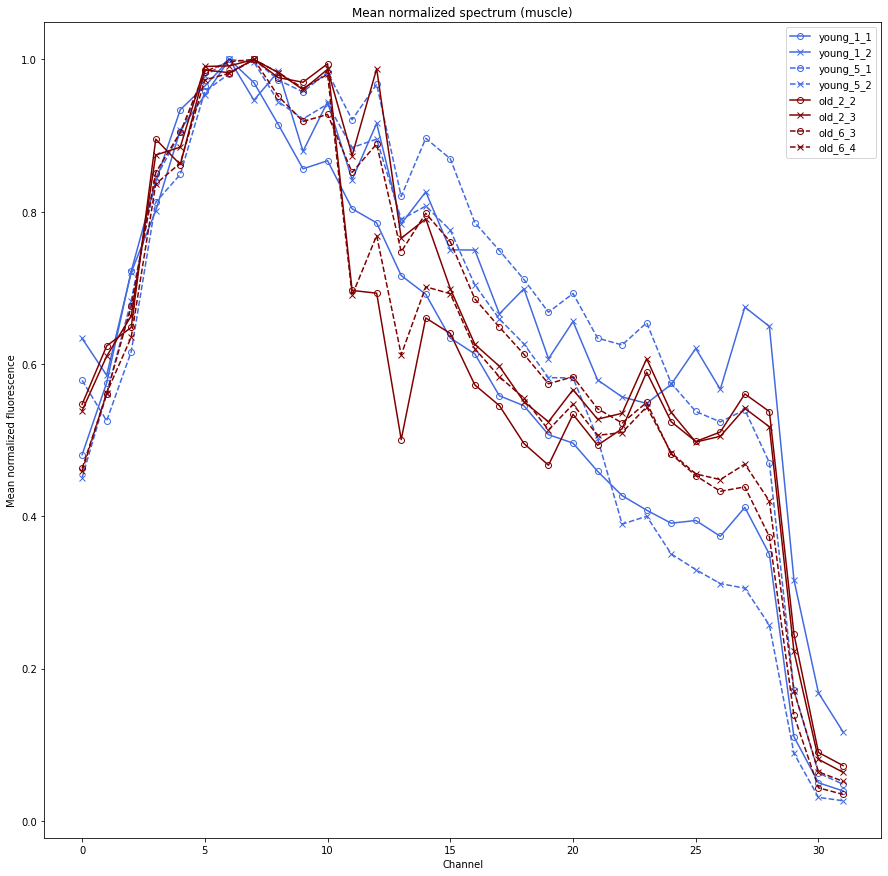

In [64]:
plt.figure(figsize=(15,15))
for name, spec in MeanS_J_nm.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='royalblue', ls=ls, marker=marker, fillstyle='none')
for name, spec in MeanS_V_nm.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='maroon', ls=ls, marker=marker, fillstyle='none')
plt.ylabel("Mean normalized fluorescence")
plt.xlabel("Channel")
plt.title("Mean normalized spectrum (not muscle)")
plt.legend()
plt.show()

## 9. Spectres médians des images (non muscle)


In [66]:
MedianS_J_nm = {}
MedianS_V_nm = {}
for name, img in raw_images.items():
  if name[0] == "j":
    MedianS_J_nm[name] = Median_spectrum(img, open_segmented_images_nm[name])
  else:
    MedianS_V_nm[name] = Median_spectrum(img, open_segmented_images_nm[name])

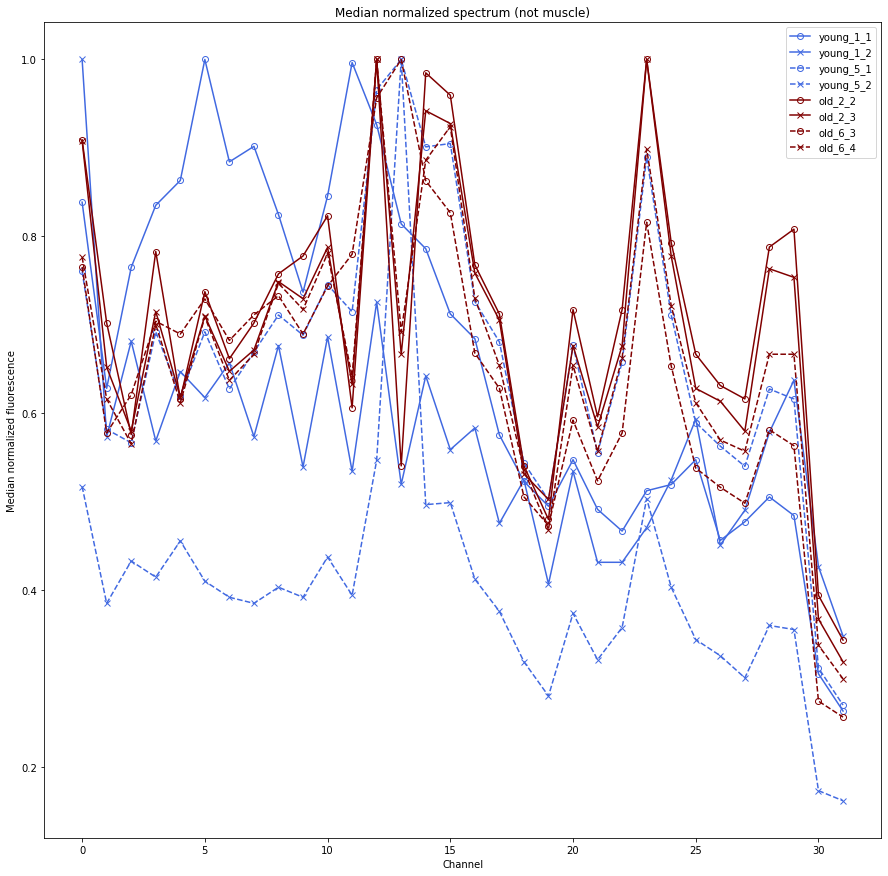

In [68]:
plt.figure(figsize=(15,15))
for name, spec in MedianS_J_nm.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='royalblue', ls=ls, marker=marker, fillstyle='none')
for name, spec in MedianS_V_nm.items():
  label = Rename(name)
  ls = esthetic[name][0]
  marker = esthetic[name][1]
  plt.plot(spec/max(spec), label=label, color='maroon', ls=ls, marker=marker, fillstyle='none')
plt.ylabel("Median normalized fluorescence")
plt.xlabel("Channel")
plt.title("Median normalized spectrum (not muscle)")
plt.legend()
plt.show()

## 10. Distribution de la fluorescence

In [ ]:
def df_muscle (img, os_img):
  df = pd.DataFrame()

  for i in range(32):
    name = "C" + str(i)
    muscle = os_img*img[:,:,:,i]
    muscle_norm = muscle.ravel()/max(muscle.ravel())
    df[name] = muscle_norm

  return df

In [ ]:
df_j5_1_740 = df_muscle(raw_images["j5_1_740nm"], open_segmented_images_m["j5_1_740nm"])
df_v6_3_740 = df_muscle(raw_images["v6_3_740nm"], open_segmented_images_m["v6_3_740nm"])
df_v2_3_740 = df_muscle(raw_images["v2_3_740nm"], open_segmented_images_m["v2_3_740nm"])

In [ ]:
def Distribution_channel (dfj, dfv, channel):
  dfj_cp = dfj.copy()
  dfv_cp = dfv.copy()

  dfj_c = dfj_cp[dfj_cp[channel]>0][channel]
  dfv_c = dfv_cp[dfv_cp[channel]>0][channel]

  dfj_c.reset_index(drop=True, inplace=True)
  dfv_c.reset_index(drop=True, inplace=True)

  return dfj_c, dfv_c

In [ ]:
dfj = df_j5_1_740
dfv = df_v6_3_740

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(20, 20))

c=0
for i in range(8):
  for j in range(4):
    channel = "C" + str(c)
    Hj, Hv = Distribution_channel(dfj, dfv, channel)
    ax = axs[i][j]
    ax.hist(Hj,bins=100,alpha=1,color="black",label="jeune",density=True,histtype="step")
    ax.legend()
    ax.hist(Hv,bins=100,alpha=1,color="lightgrey",label="vieux",density=True,histtype="step")
    ax.legend()
    ax.set_title(channel)
    c+=1

plt.show()

## 11. Test de Mann-Whitney

The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.

In [ ]:
def MannWhitney_Test (dfj, dfv):
  df_MW = pd.DataFrame(columns=["statistics","p-values"])

  for i in range(32):
    channel = "C" + str(i)
    dfj_c, dfv_c = Distribution_channel(dfj, dfv, channel)
    df_MW.loc[i,:] = mannwhitneyu(dfj_c.to_numpy(), dfv_c.to_numpy())

  return df_MW

In [ ]:
MannWhitney_Test(dfj, dfv)

In [ ]:
MannWhitney_Test(dfj, df_v2_3_740)

In [ ]:
MannWhitney_Test(df_v6_3_740, df_v2_3_740)